# FWI on field data (CGG Broadseis)

by Oleg Ovcharenko

oleg.ovcharenko@kaust.edu.sa

KAUST, 2021

In [2]:
import os
import sys
#api._cmd('conda activate torch2')
print(f'Python: {sys.prefix}')
import copy
from glob import glob
# import glob
import numpy as np
import importlib
import multiprocessing
import segyio
from scipy import signal, ndimage
from natsort import natsorted
from skimage.transform import rescale, resize
# append path with actual source files to sys.path
sys.path.append(os.path.abspath('../codes_server'))
sys.path.append(os.path.abspath('./utils'))
from utils import shared as sd
from utils import loaders as ld
from utils import vis
from IPython.display import clear_output
from F_utils import *
from F_fwi import *
import pyapi_denise_pavel as api
api._cmd('source /home/plotnips/Madagascar/share/madagascar/etc/env.sh')
api._cmd('source ~/.bashrc')
# create_sbatch_file_for_fwi_folder('./for_pasha/out_for_pasha/fwi_full_spectrum_vanilla')
# results_path='./out_for_pasha/fwi_full_spectrum'
# os.system(f"rm -r {results_path}")
print(filter_seismic_data)
d=api.Denise('/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master',verbose=1)
print(d.get_shots_from_datadir)
print(d.get_shots_from_directory)
print(sys.path)
import nest_asyncio
nest_asyncio.apply()

Python: /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/env
<function filter_seismic_data at 0x154db03a28c8>
Init Python 3 API for Denise-Black-Edition.
Check binary in /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/bin/denise
Parse /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/par/DENISE_marm_OBC.inp
Current directory is /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
Init paths at ./outputs/
<bound method Denise.get_shots_from_datadir of DENISE-Black-Edition:
	/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master
Save folder:
	./outputs/
Run .help() for more details>
<bound method Denise.get_shots_from_directory of DENISE-Black-Edition:
	/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master
Save folder:
	./outputs/
Run .help() for more details>
['', '/home/plotnips/Madagascar/lib/python3.7/site-package

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# mpl.rcParams['figure.dpi']= 100
fontsize = 10
params = {
    # 'text.latex.preamble': ['\\usepackage{gensymb}'],
    # 'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'figure.dpi' : 300,
    # 'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize':fontsize,  # fontsize for x and y labels (was 10)
    'axes.titlesize':fontsize,
    'font.size':fontsize,  # was 10
    'legend.fontsize': fontsize,  # was 10
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize,
    # 'text.usetex': True,
    # 'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
mpl.rcParams.update(params)

# Init Denise API

In [4]:
root_fwi = './out_for_pasha/'
denise_root = '../'
d = api.Denise(denise_root, verbose=0)
d.save_folder = root_fwi
d.set_paths()
def divmax(x): return x / np.max(np.abs(x))

Init Python 3 API for Denise-Black-Edition.
Check binary in ../bin/denise


In [6]:
print(os.getcwd())
# denise_dir='../fwi/cgg_real_data/cnn_14_1/fld'
denise_path='/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/fwi/cgg_real_data/cnn_14_1/model__cgg_lin_vp_long/'
denise_dir=os.path.join(denise_path,'fld')
d=parse_denise_folder(denise_path,denise_root='../')

shots_field,filenames_field=d.get_shots_from_directory(os.path.join(denise_dir,'su'),keys=['_p'],return_filenames=True)
su_field_path1 = os.path.join(os.getcwd(),'su_field_high_pass_5_hz/')
shots_modelled,filenames_modelled=d.get_shots_from_directory(os.path.join(denise_dir,'su_modelled'),keys=['_p'],return_filenames=True)
print(shots_field[0].shape)

/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
Init Python 3 API for Denise-Black-Edition.
Check binary in ../bin/denise
len(taper)= 5
(324, 3000)


13
65


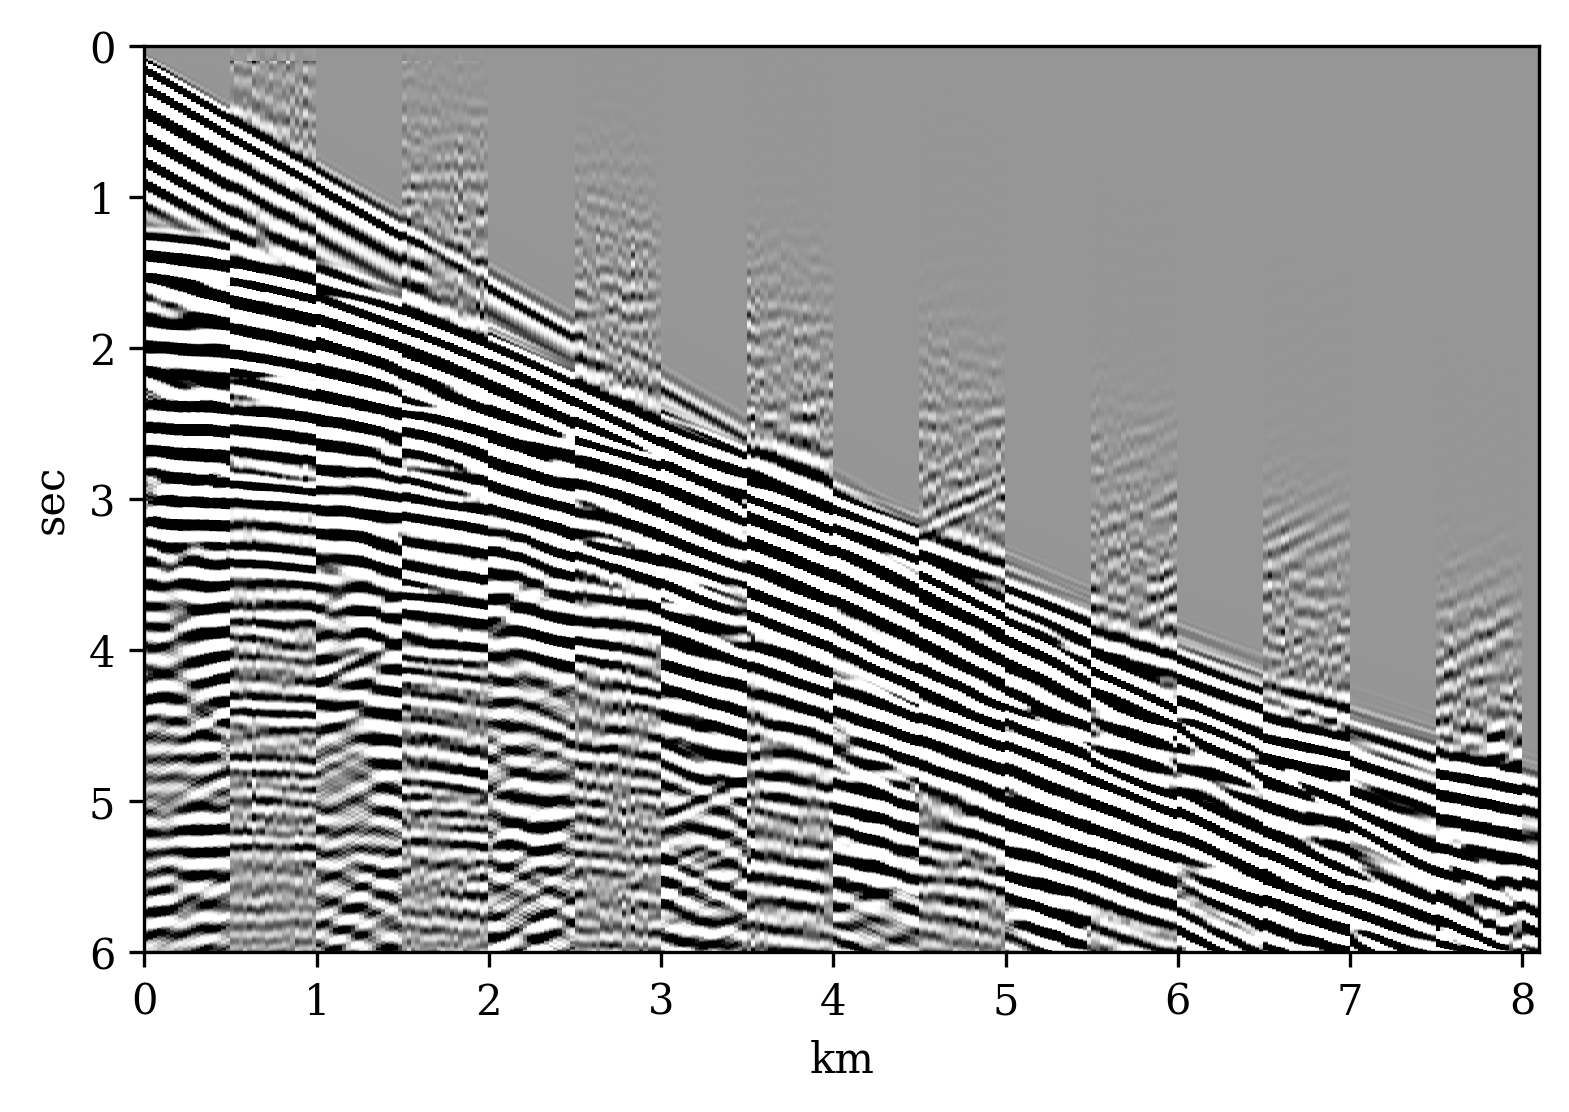

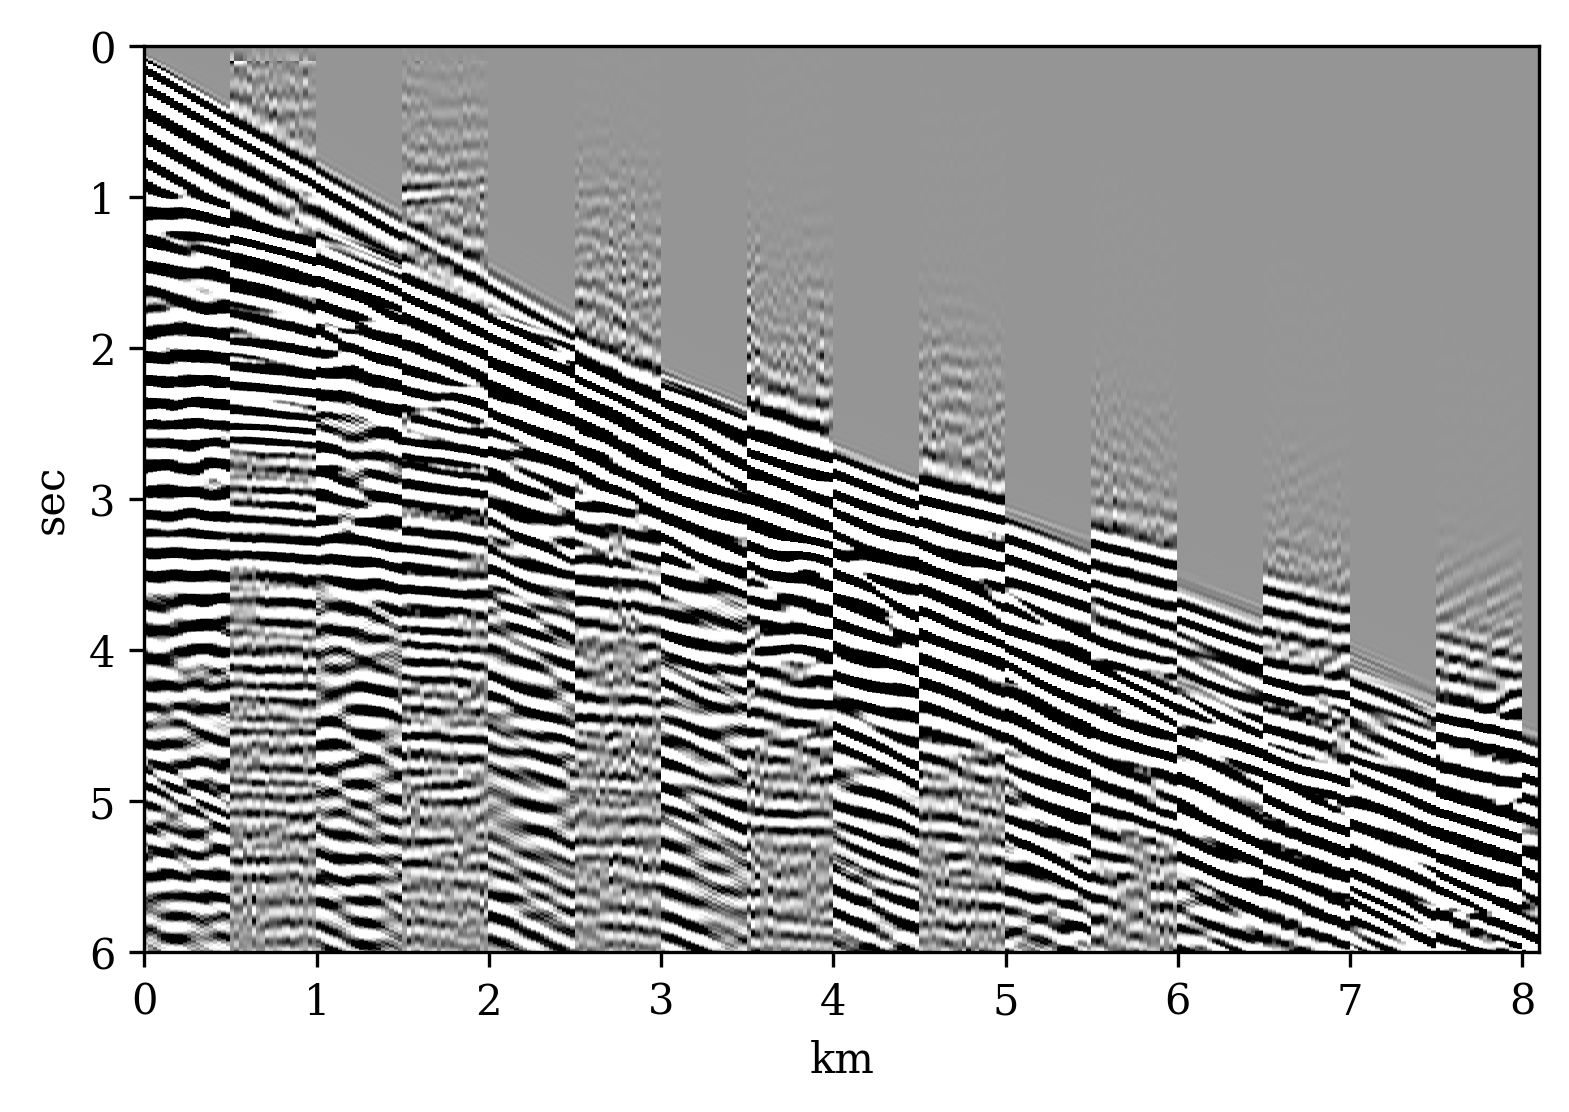

In [5]:
for ishot in [13, 65]:
    print(ishot)
    shot_s = divmax(shots_modelled[ishot])
    shot_f = divmax(shots_field[ishot])
    # shot_f = divmax(shots_field[ishot, :, ::d.NDT])
#     vis.plot_shot(np.concatenate([np.flip(shot_s, 0), shot_f], axis=0), pclip=0.05)
    vis.plot_compare_stripes(shot_s, shot_f, pclip=0.0125, colorbar=False, dt=0.002, dx=25)

# Get acquitision details

In [6]:
shot_id_min = 60
n_selected_shots = 80
njump_src = 8
shot_id_max = shot_id_min + (n_selected_shots-1) * njump_src

80/80
Before prep:	(80, 648, 3526)
Data cube:	(80, 324, 3000)
Extended cube:	(80, 324, 3100)
[80, 324, 3050] (80, 324, 3000)
[80, 324, 3150] (80, 324, 3100)
25.0
Assume even average spacing between sources
 150.0 m ~ 6 grid nodes
First source:	1125.0 m
Last source:	12950.0 m
150.0
name:	
x	(80,):	min: 1125.0	max: 12975.0
y	(80,):	min: 50.0	max: 50.0
wavelets:	None
z	(80,):	min: 0.0	max: 0.0
nshot:	80
td	(80,):	min: 0.0	max: 0.0
fc	(80,):	min: 8.0	max: 8.0
amp	(80,):	min: 1.0	max: 1.0
angle	(80,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(80,):	min: 1.0	max: 1.0
drec:	25.0 m
x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
name:	]
x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
name:	]
(152, 600)
(152, 600)
(152, 500)
12500.0


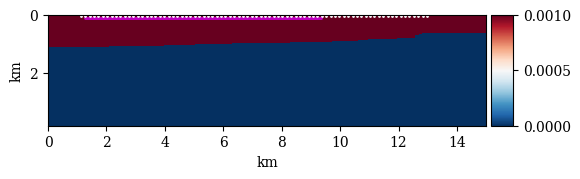

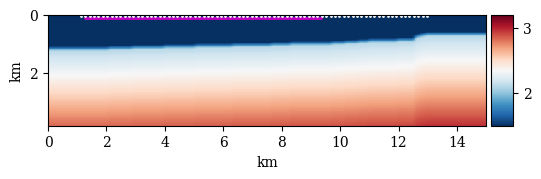

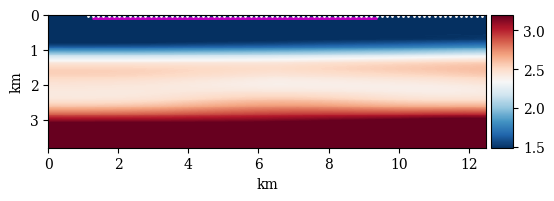

In [7]:
%run ./fwi_shared_check.ipynb

In [22]:
mpl.rcParams['figure.dpi']= 300
d.verbose = 2
limits_vp = {'vmin': model.vp.min() / 1000, 'vmax': model.vp.max() / 1000}
models,fnames=d.get_fwi_models(['vp', 'stage'],return_filenames=True)
print(fnames)
print(len(fnames))
print(log_location)
print(len(wlog))
log_dict = {'data':wlog, 'loc': log_loc}
print(log_loc)
print(log_loc/25)

# for m, f in zip(models, fnames):
#     vis.plot_log_model(m, dx, nx0, nz0, src, log=wlog, log_location=log_location, **limits_vp)

Parse files from /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/fwi/cgg_real_data/cnn_14_1/model__cgg_lin_vp_long/fld/model which contain ['vp', 'stage']
Found 90, e.g. /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/fwi/cgg_real_data/cnn_14_1/model__cgg_lin_vp_long/fld/model/modelTest_vs_stage_1_it_5.bin
['/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/fwi/cgg_real_data/cnn_14_1/model__cgg_lin_vp_long/fld/model/modelTest_rho_stage_1_it_1.bin', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/fwi/cgg_real_data/cnn_14_1/model__cgg_lin_vp_long/fld/model/modelTest_rho_stage_1_it_2.bin', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/fwi/cgg_real_data/cnn_14_1/model__cgg_lin_vp_long/fld/model/modelTest_rho_stage_1_it_3.bin', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/fwi/cgg_real_data/cnn_14_1/model__cgg_lin_

### Well-logs
Plot logs in true model (dashed) and inverted models (solid) for every inversion stage

None
dict_keys(['vp', 'vs', 'rho'])
Parse files from /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/fwi/cgg_real_data/cnn_14_1/model__cgg_lin_vp_long/fld/model which contain ['vp_stage']
Found 30, e.g. /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/fwi/cgg_real_data/cnn_14_1/model__cgg_lin_vp_long/fld/model/modelTest_vp_stage_2_it_3.bin
['/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/fwi/cgg_real_data/cnn_14_1/model__cgg_lin_vp_long/fld/model/modelTest_vp_stage_1_it_1.bin', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/fwi/cgg_real_data/cnn_14_1/model__cgg_lin_vp_long/fld/model/modelTest_vp_stage_1_it_2.bin', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/fwi/cgg_real_data/cnn_14_1/model__cgg_lin_vp_long/fld/model/modelTest_vp_stage_1_it_3.bin', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/fwi/cgg_real

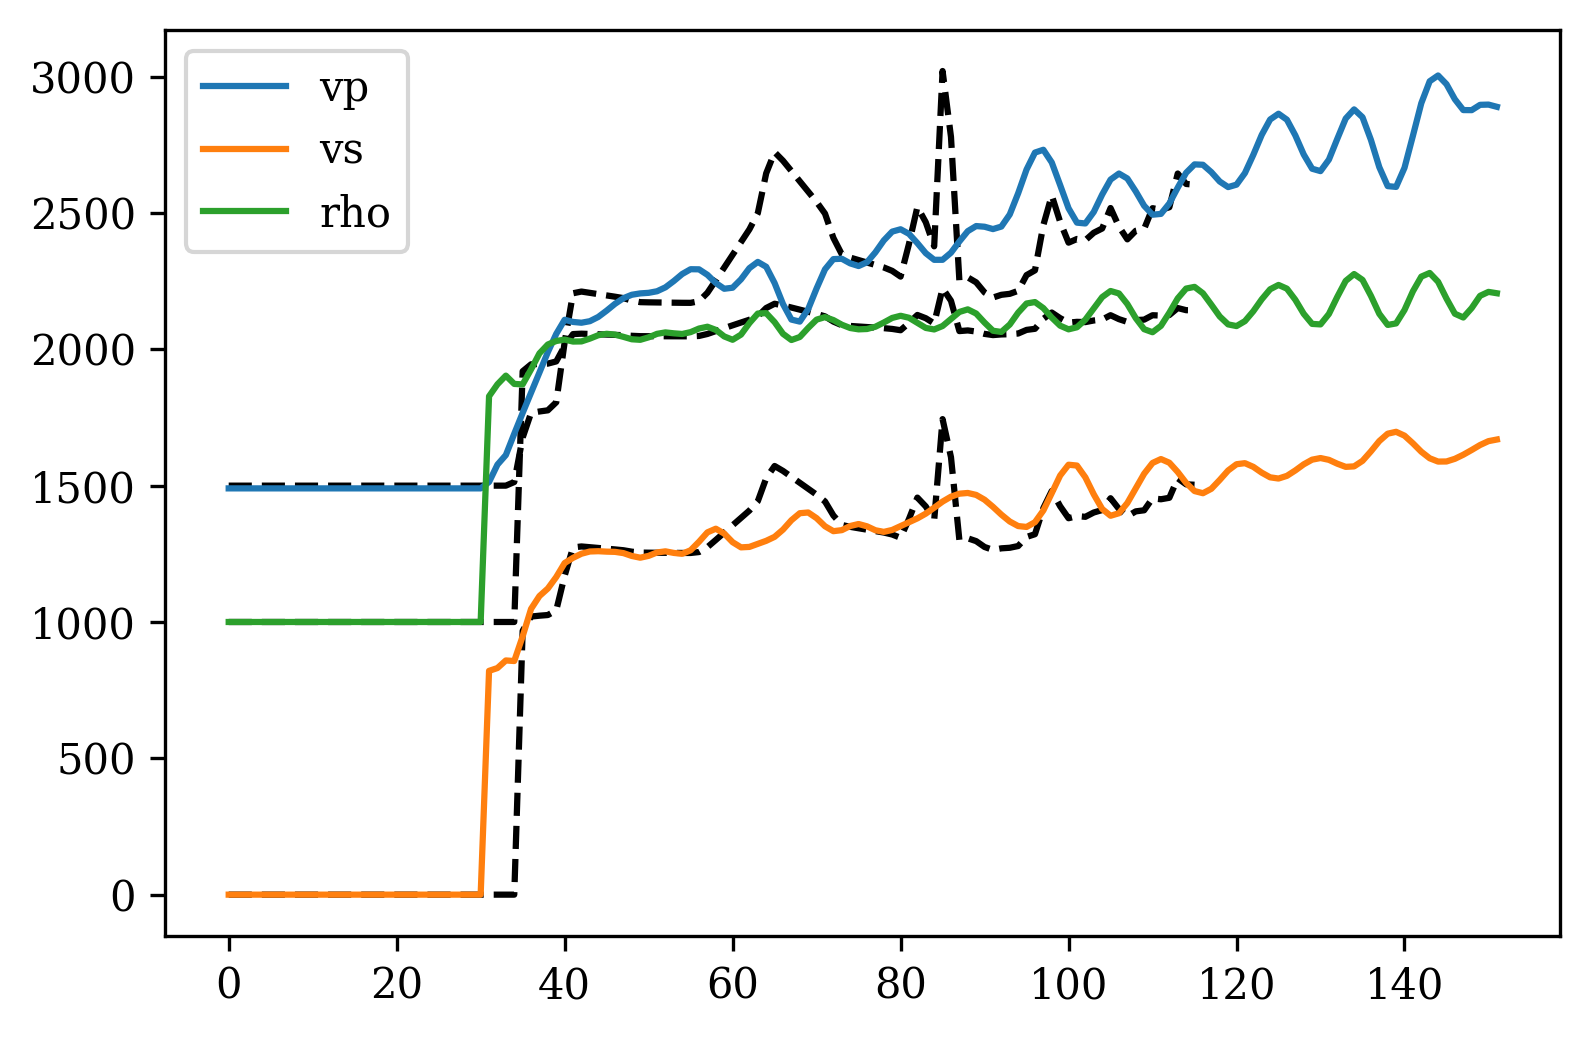

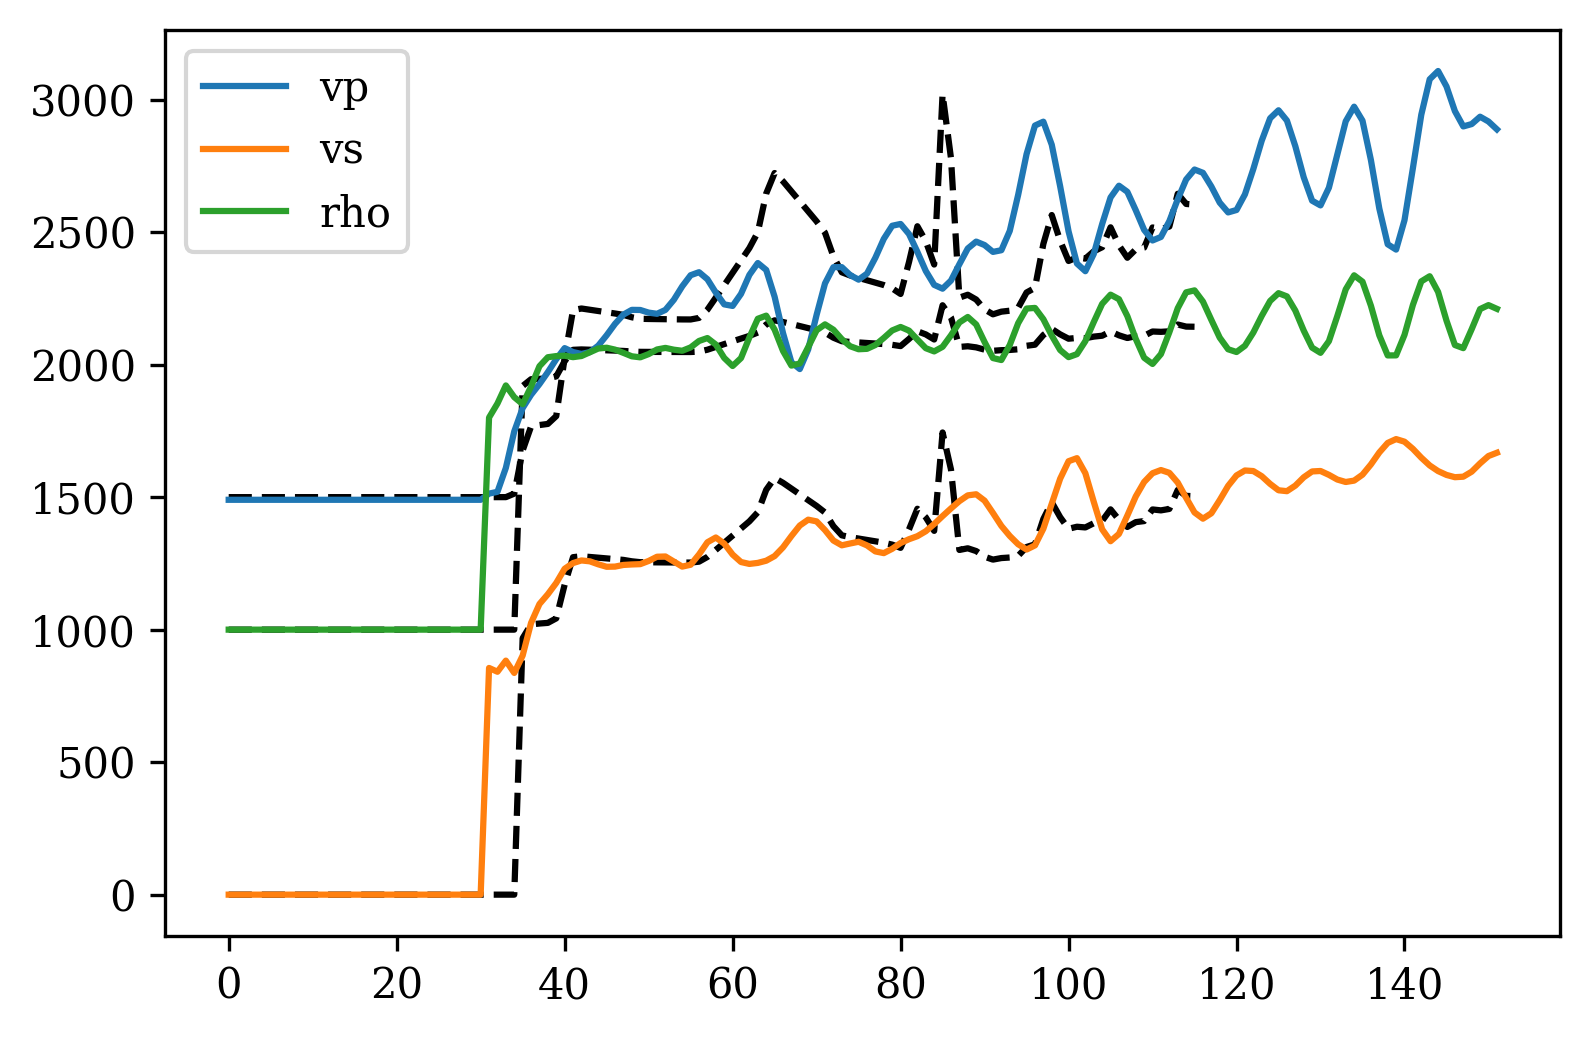

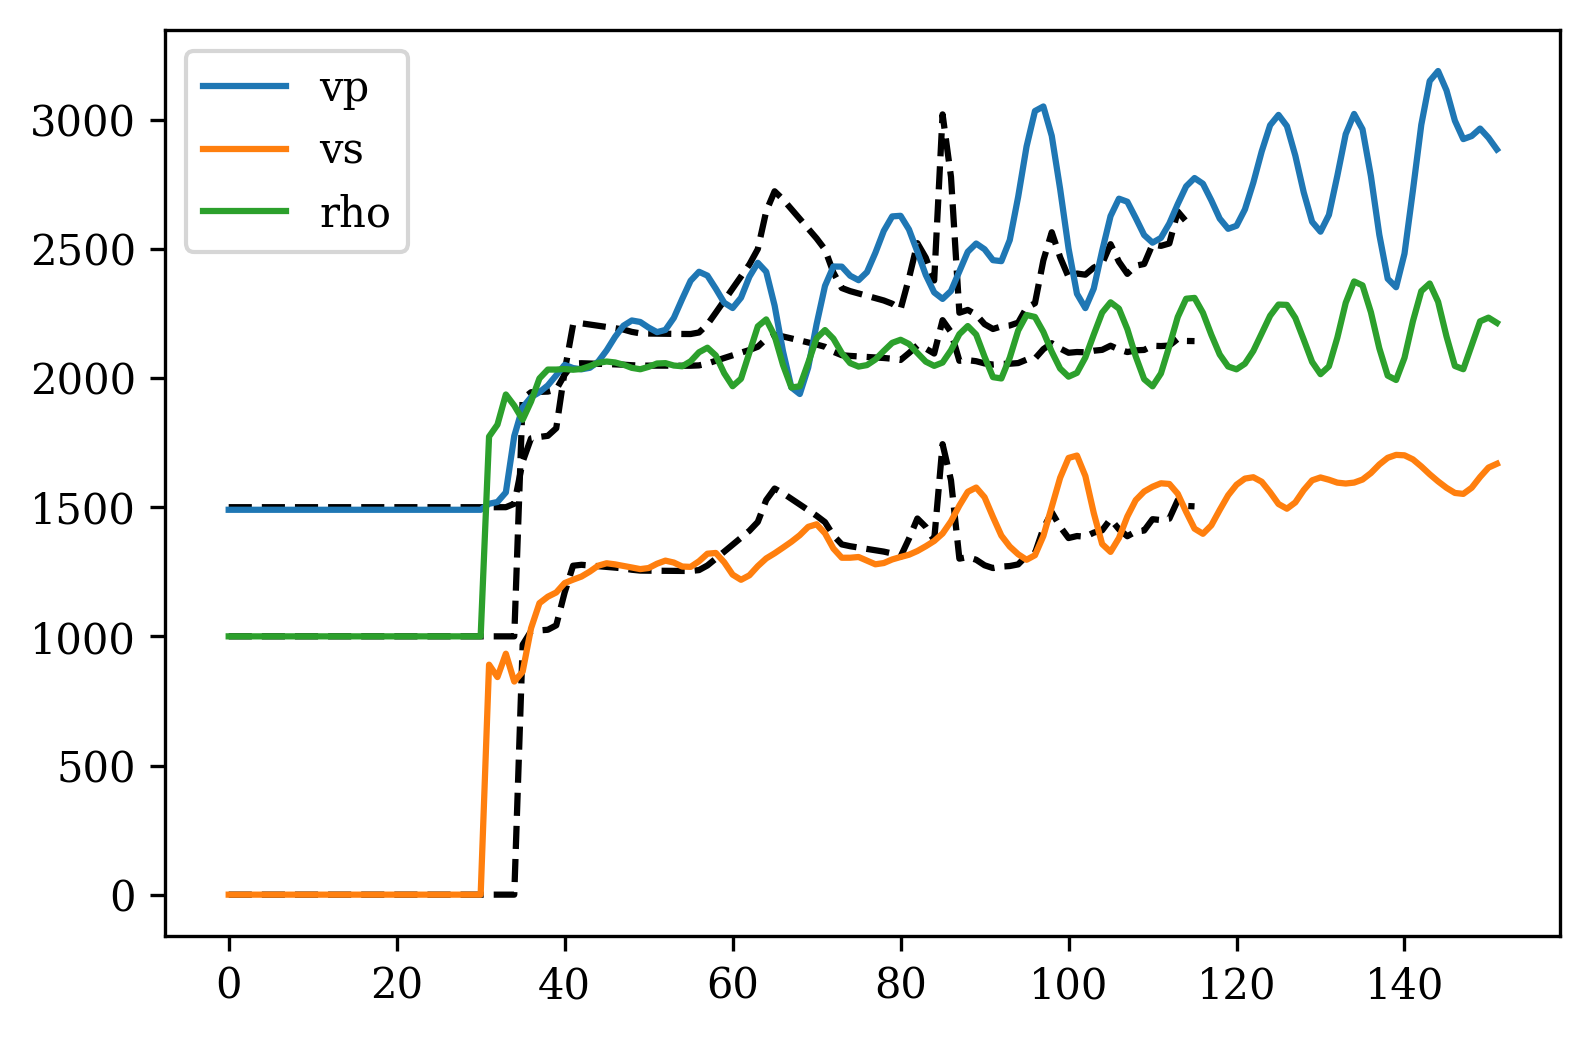

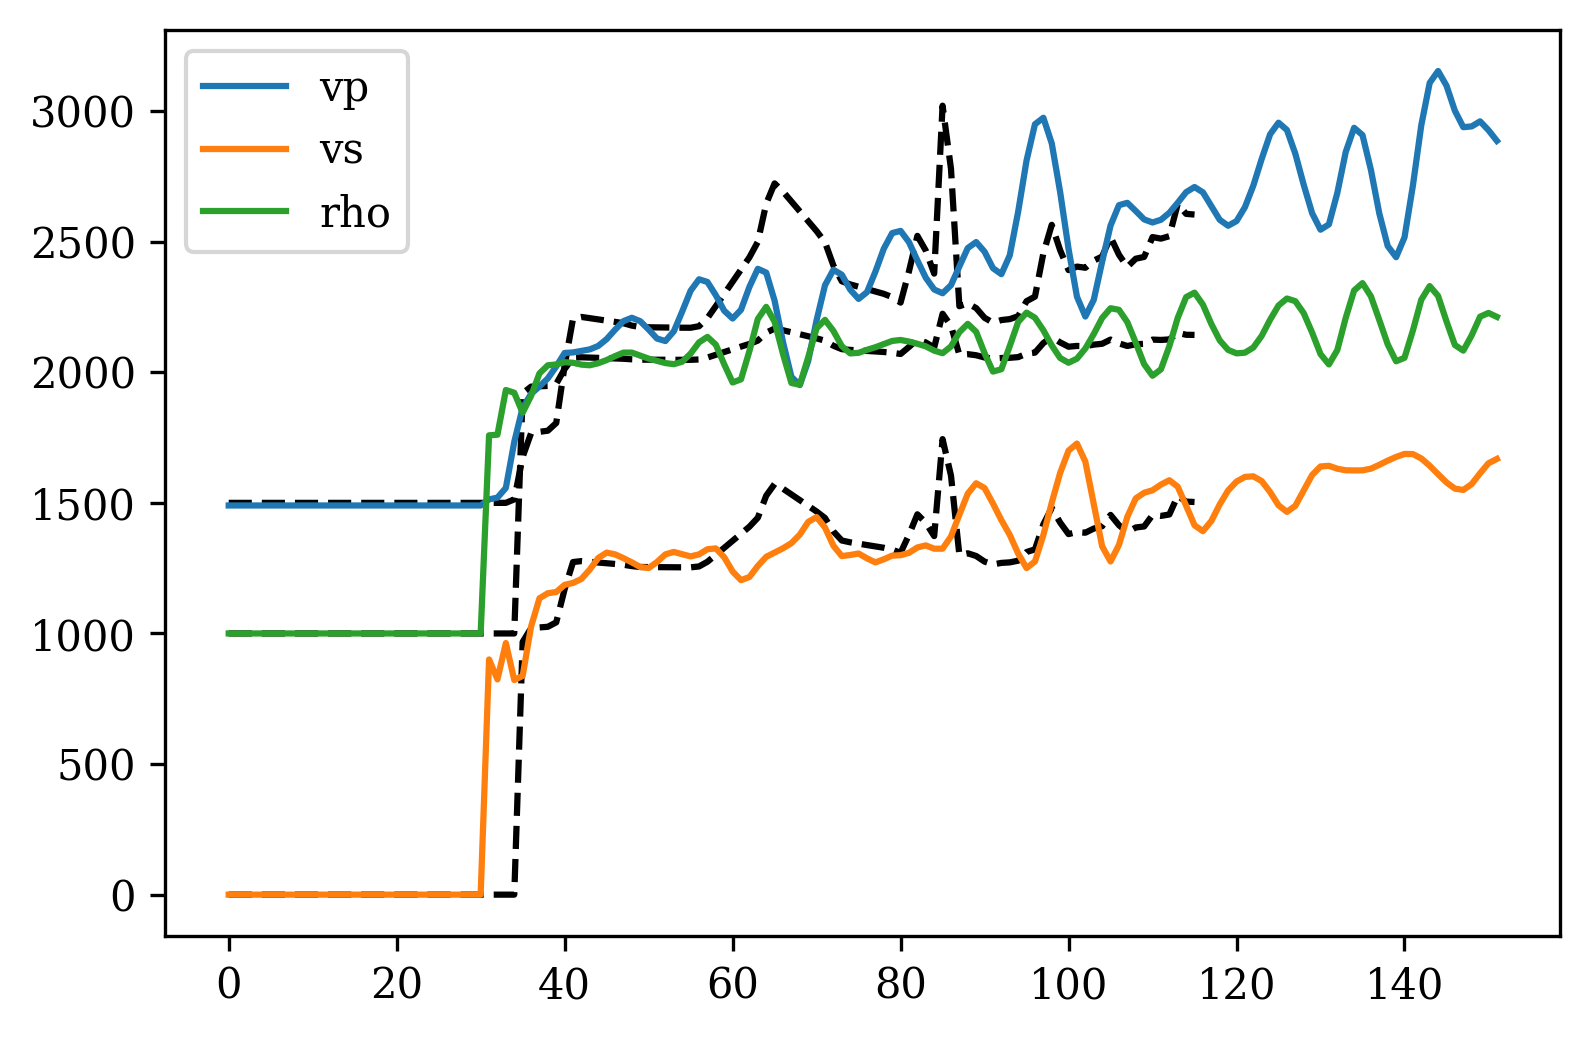

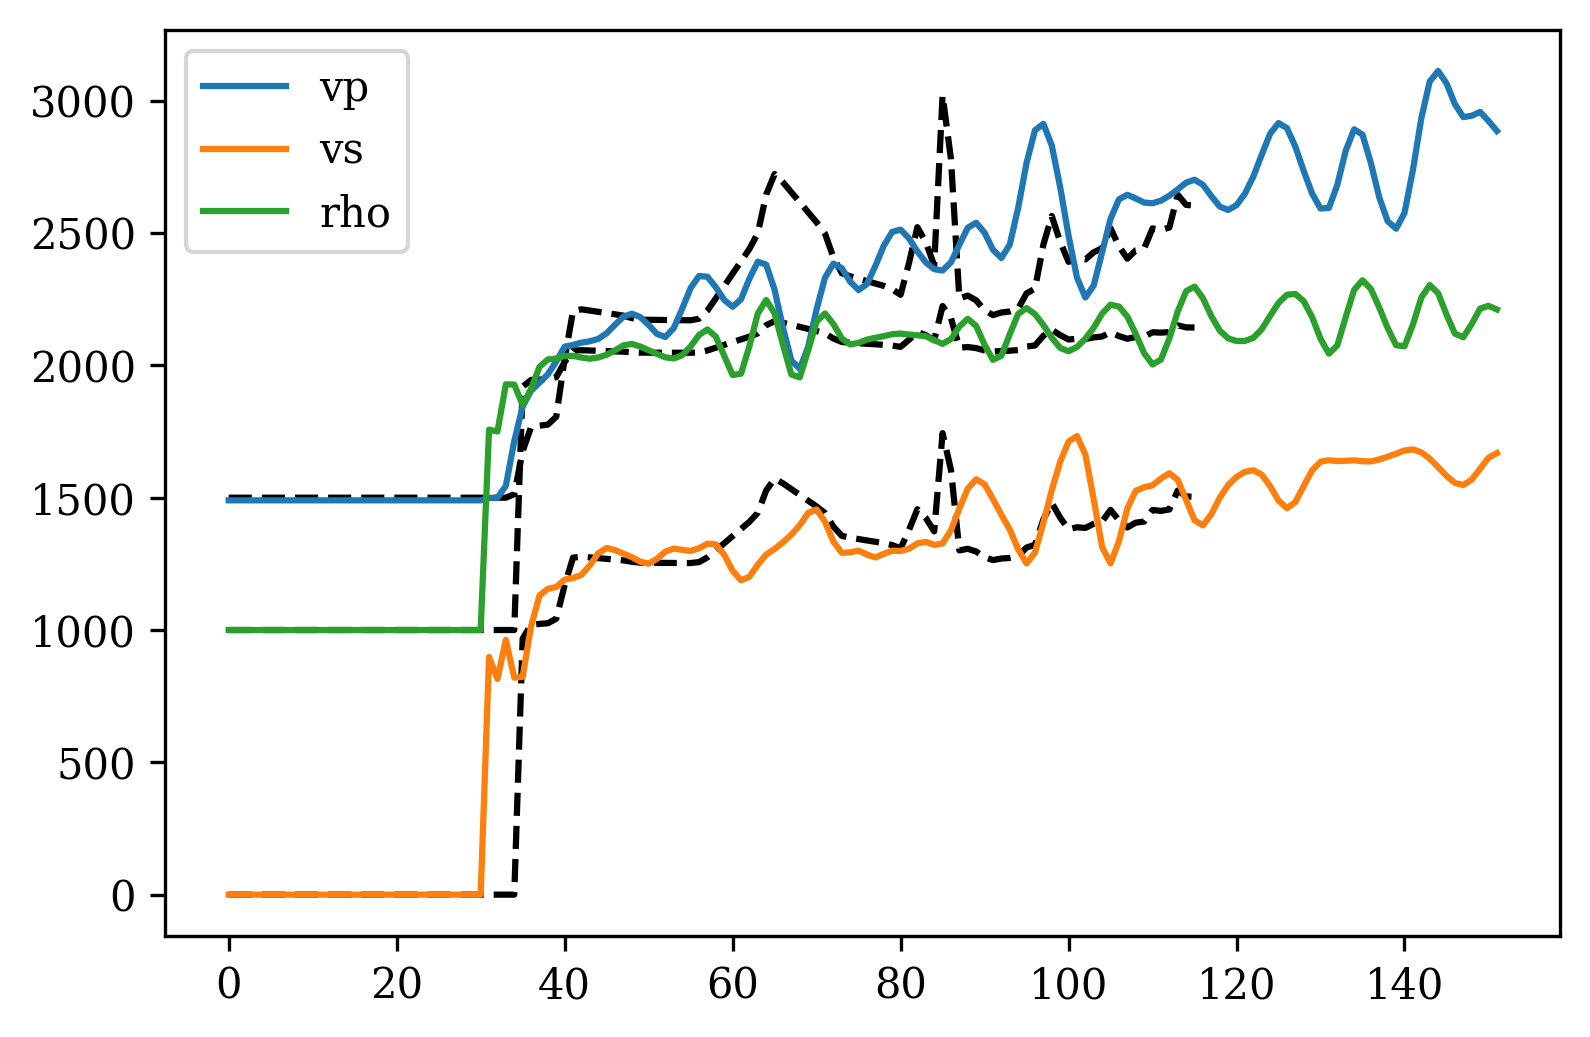

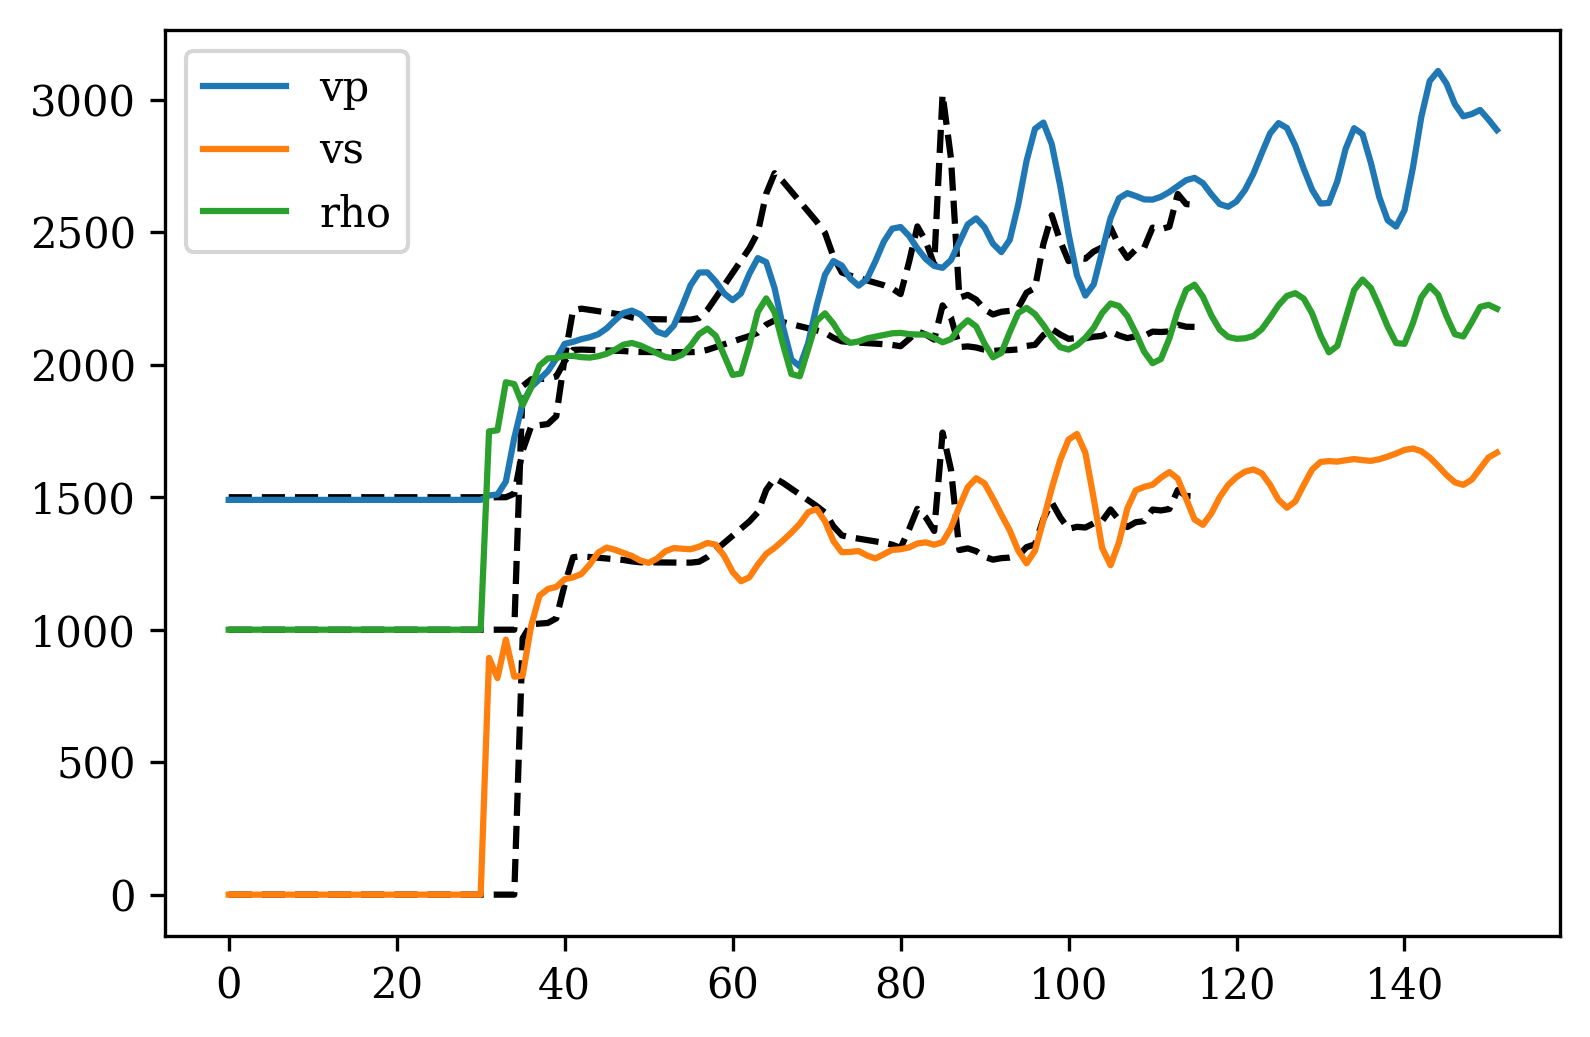

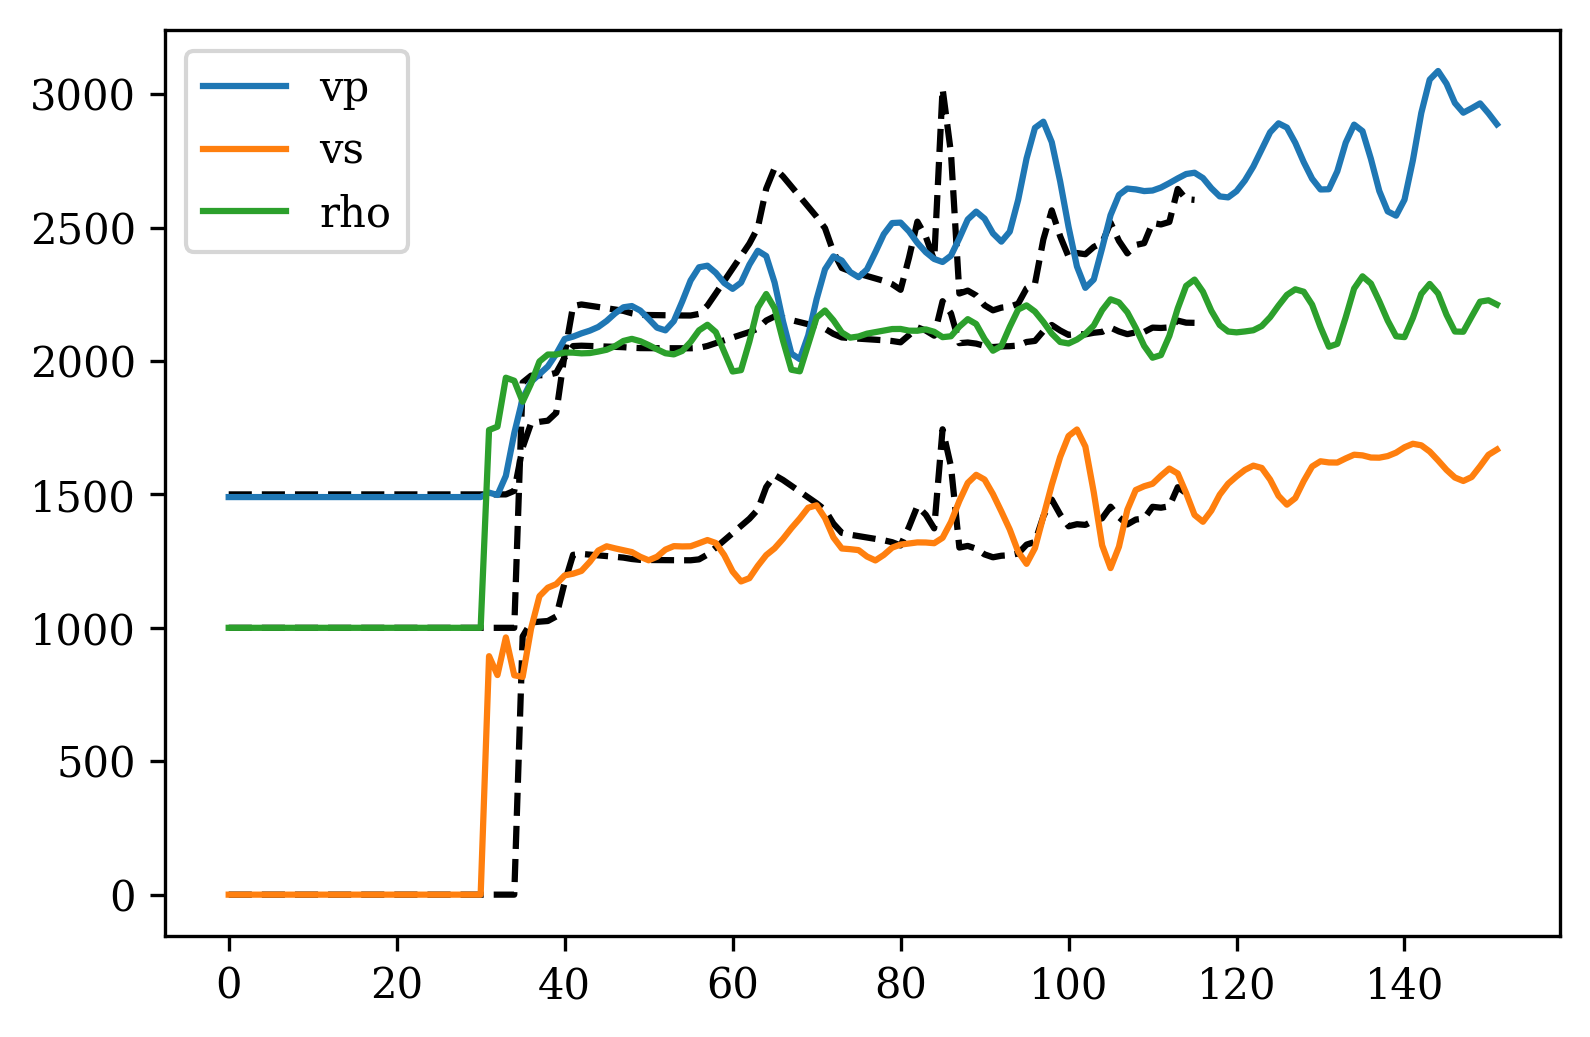

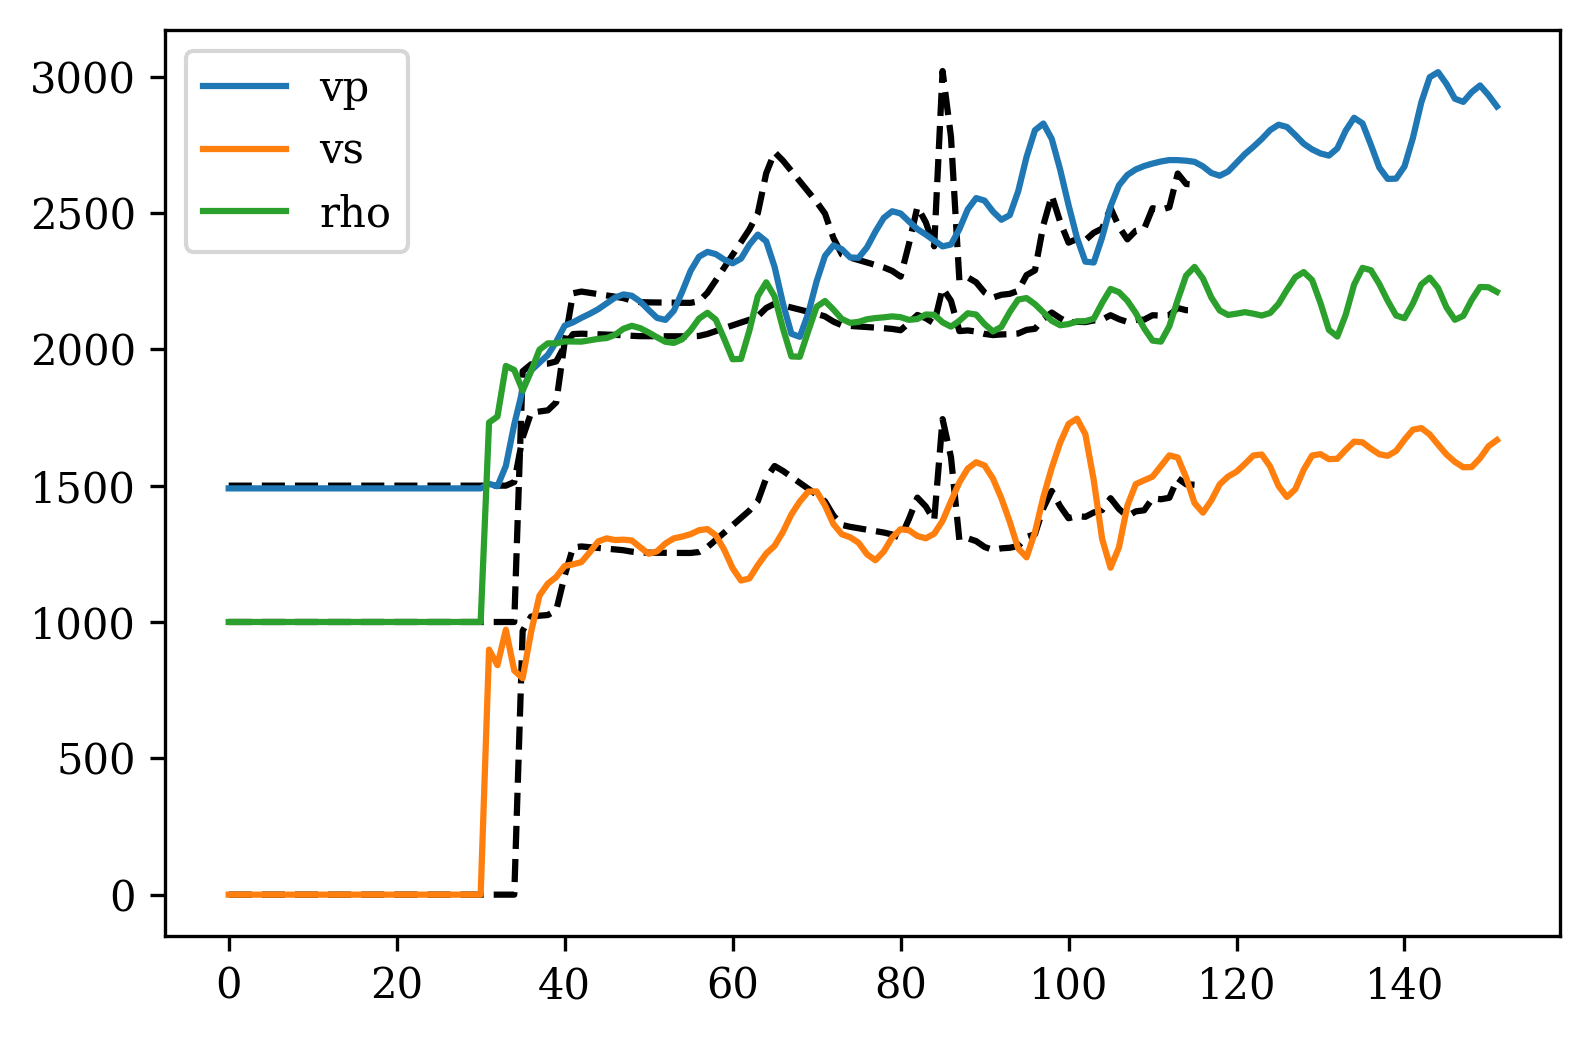

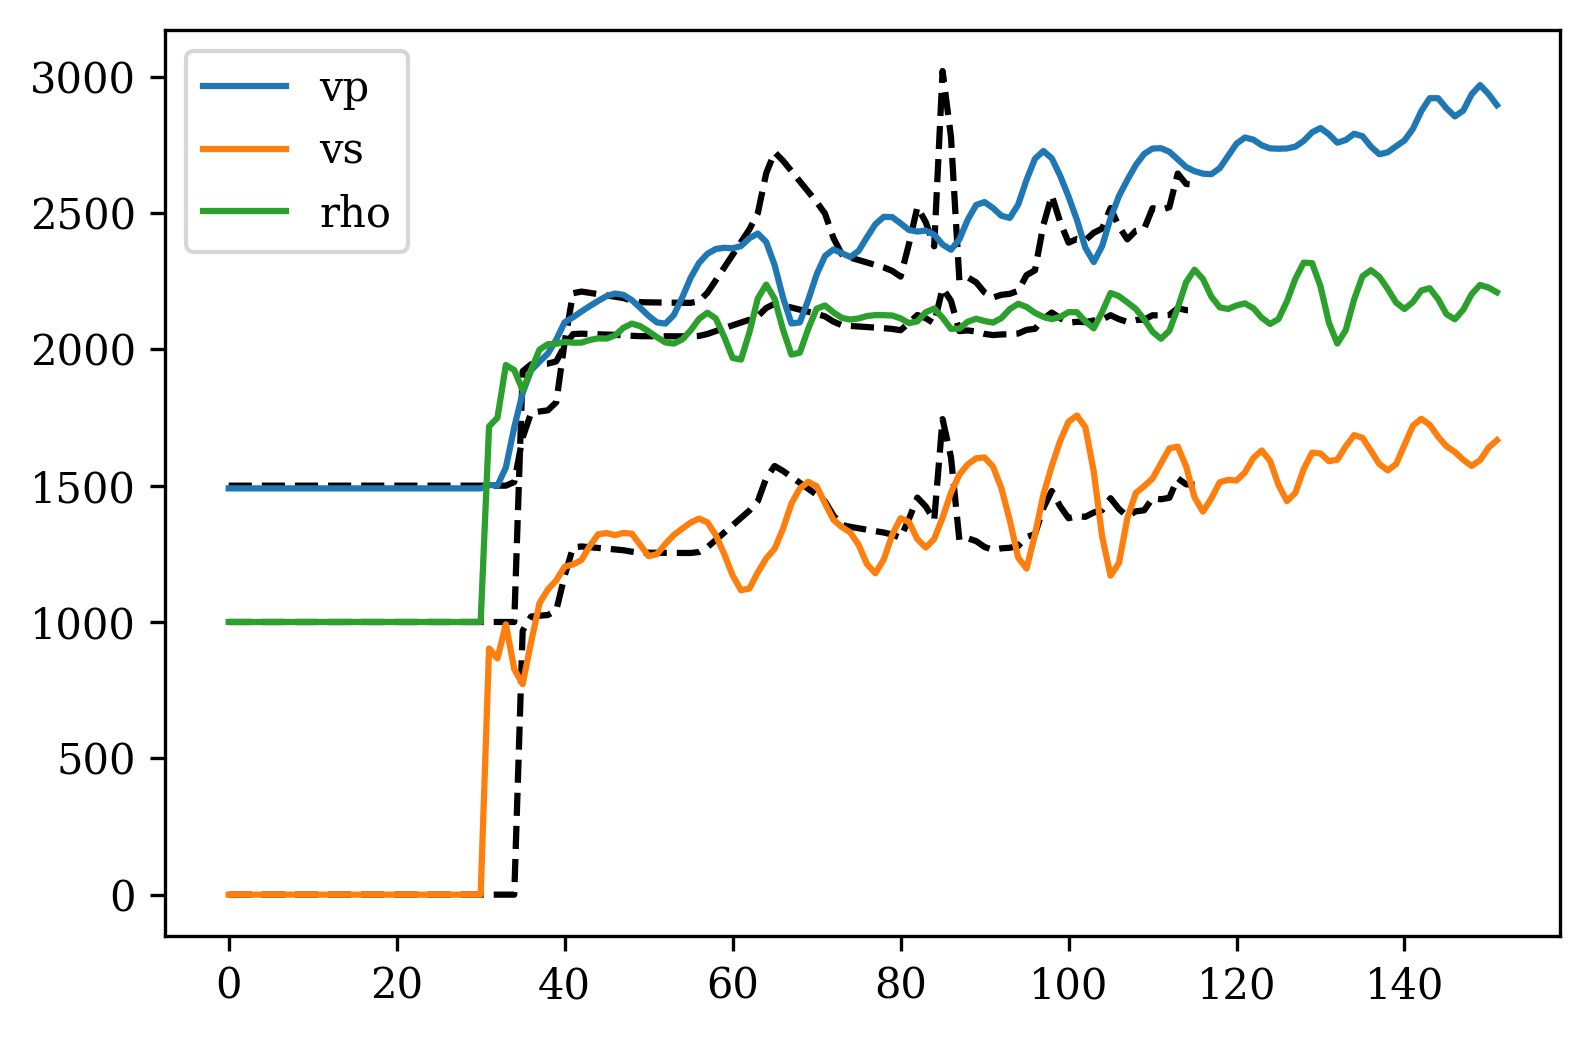

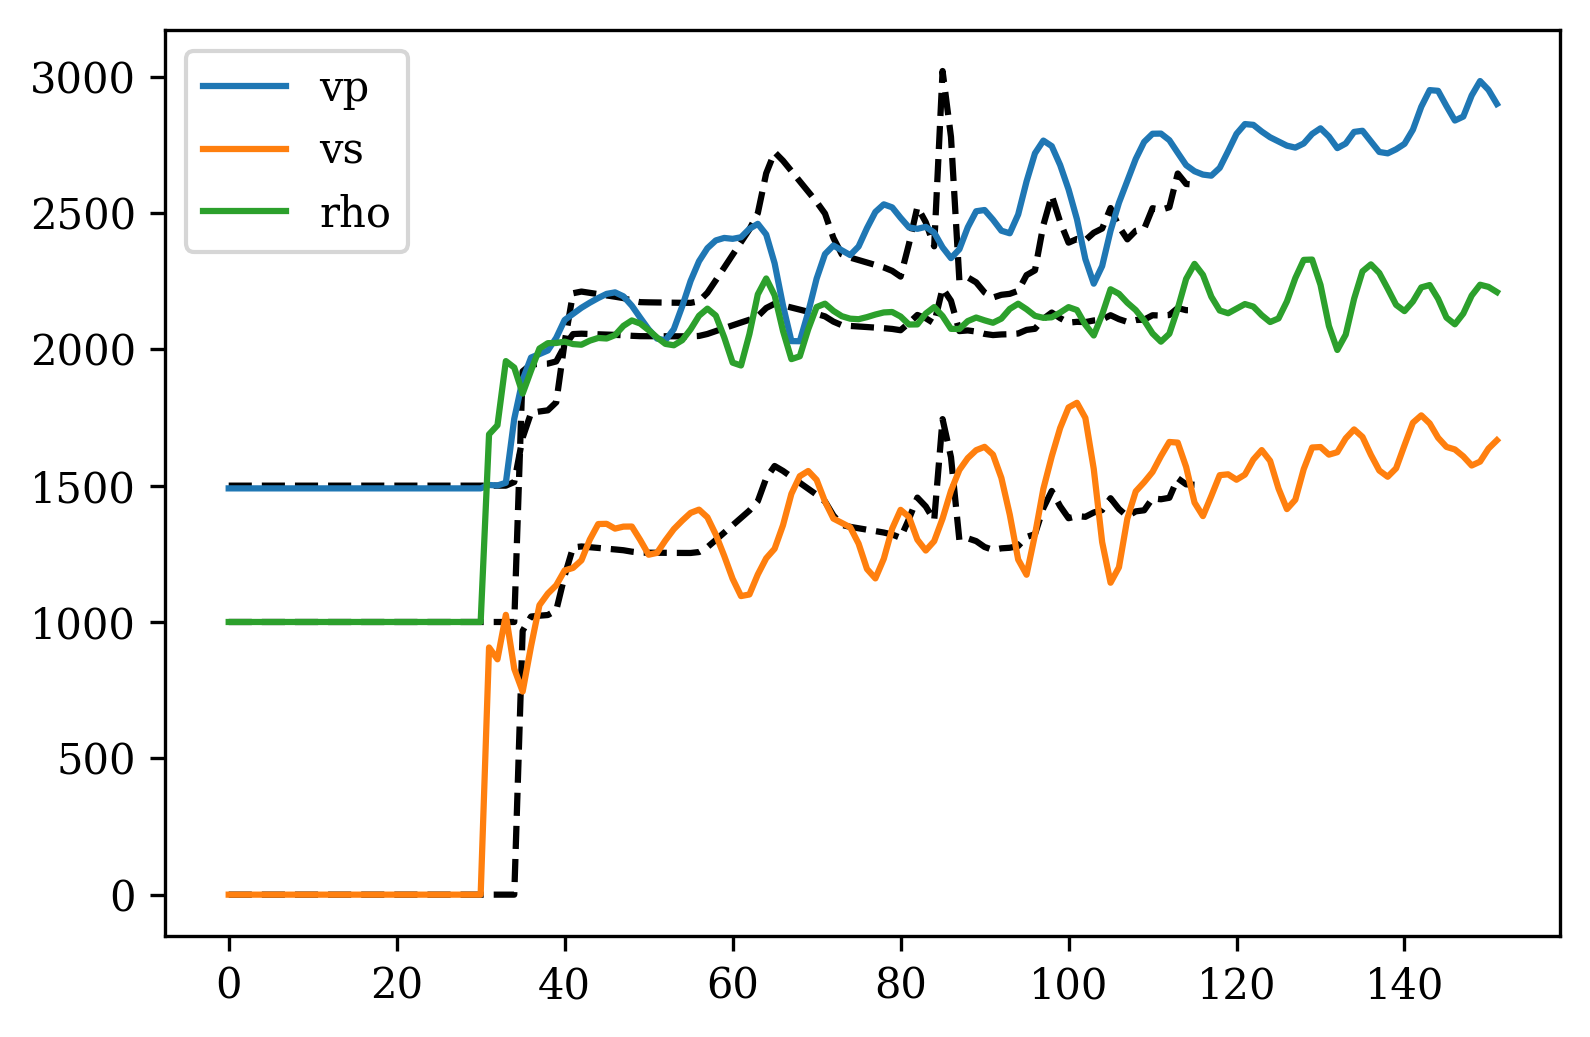

In [34]:
# Load inverted models from all stages
vvr = {'vp': None, 'vs': None, 'rho': None}
print(vvr['vp'])
print(vvr.keys())
for k in vvr.keys():
    vvr[k], fnames = d.get_fwi_models([k + '_stage'], return_filenames=True)
    print(fnames)

# print(vvr)

for i in range(len(vvr['vp'])):
    plot_logs(model_log, api.Model(vvr['vp'][i], vvr['vs'][i], vvr['rho'][i], dx), log_idx)

### Gradients

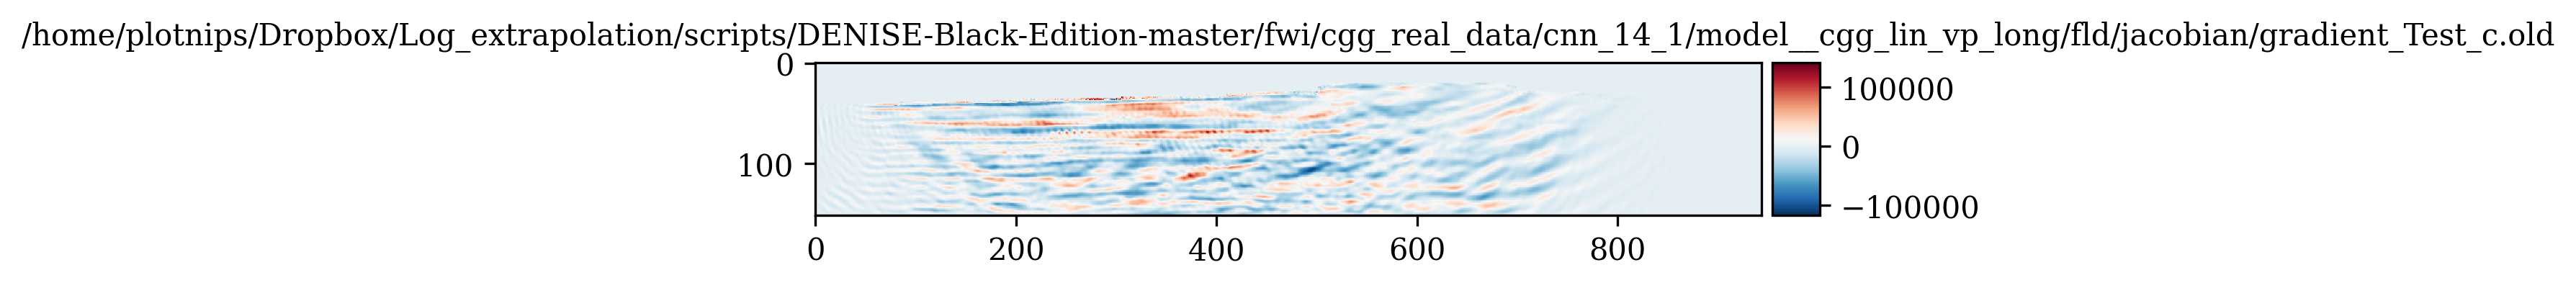

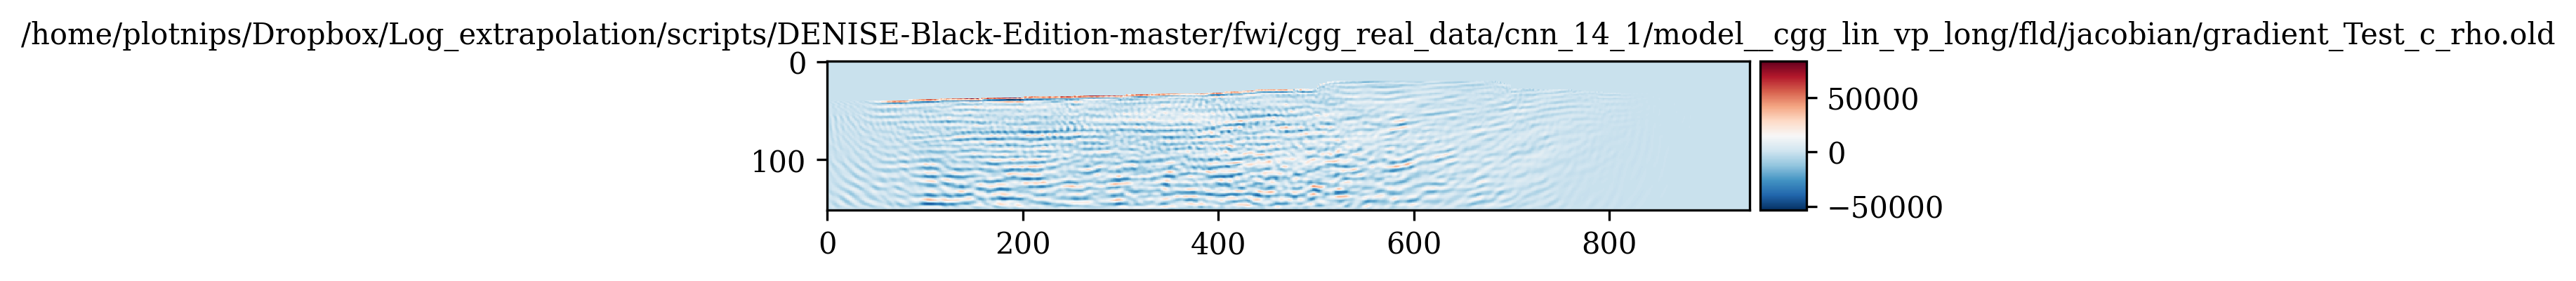

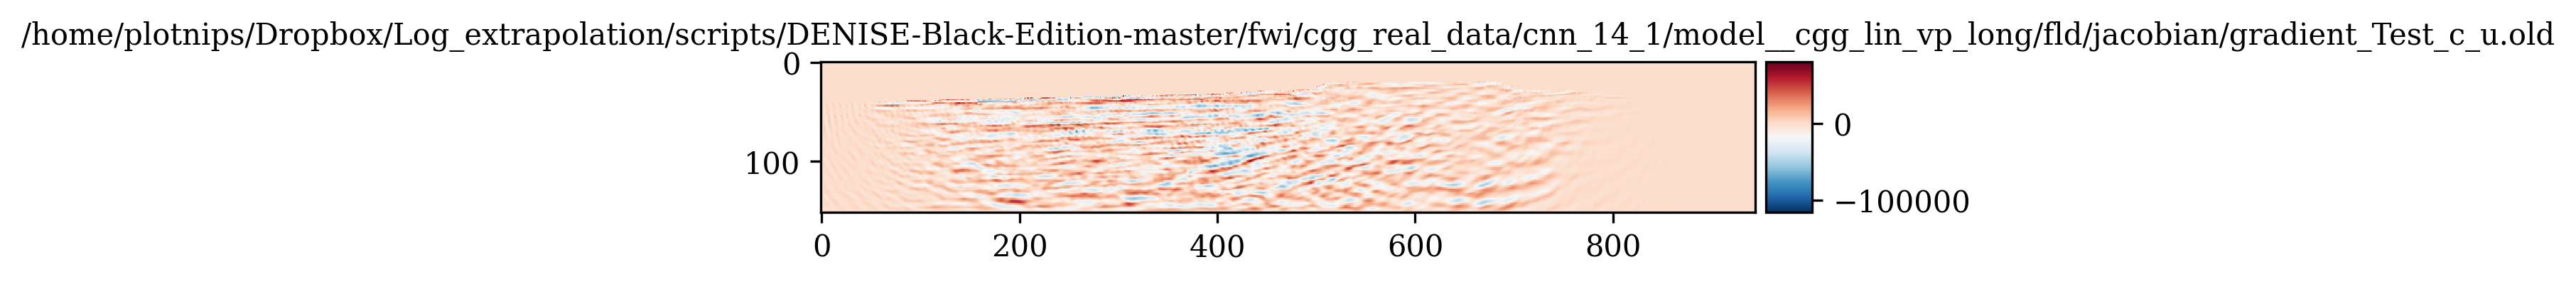

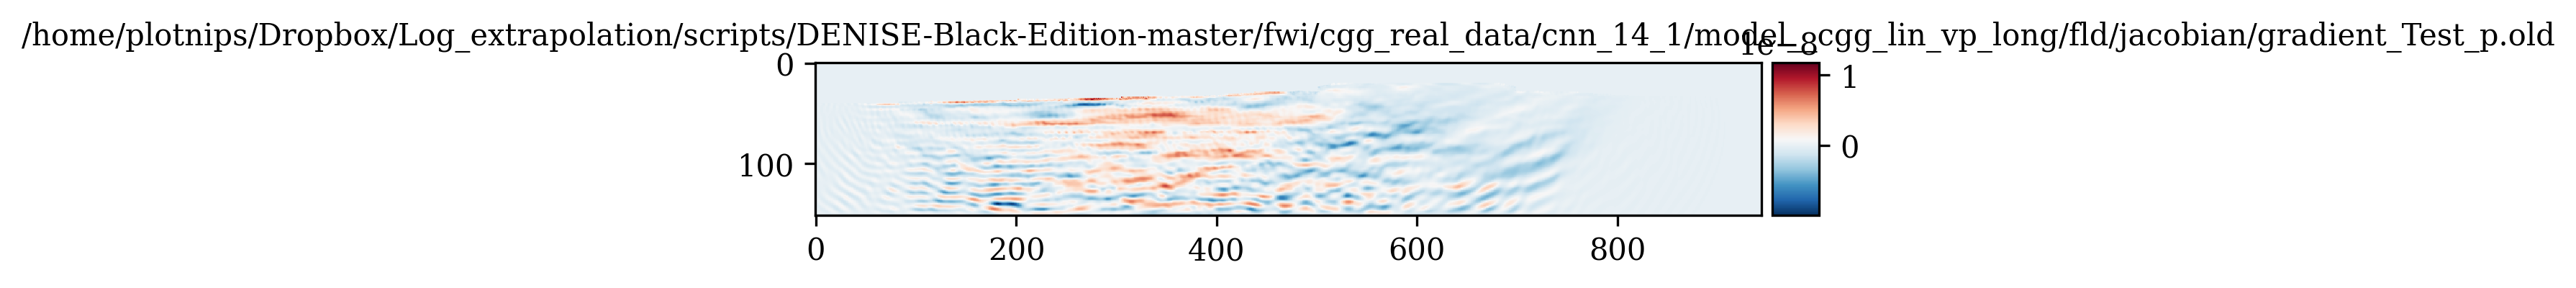

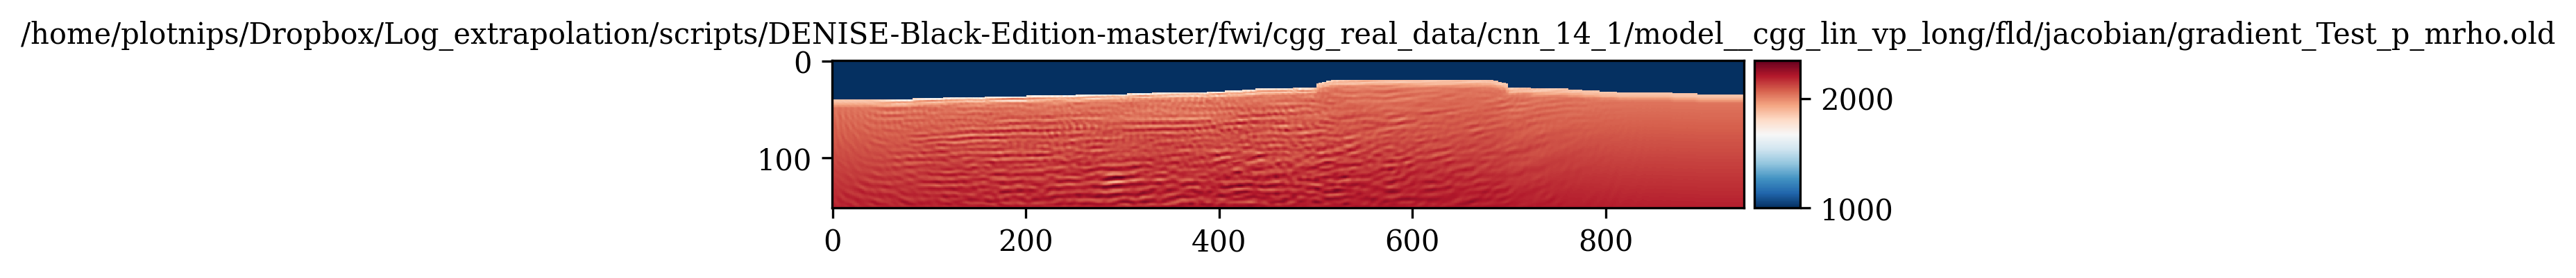

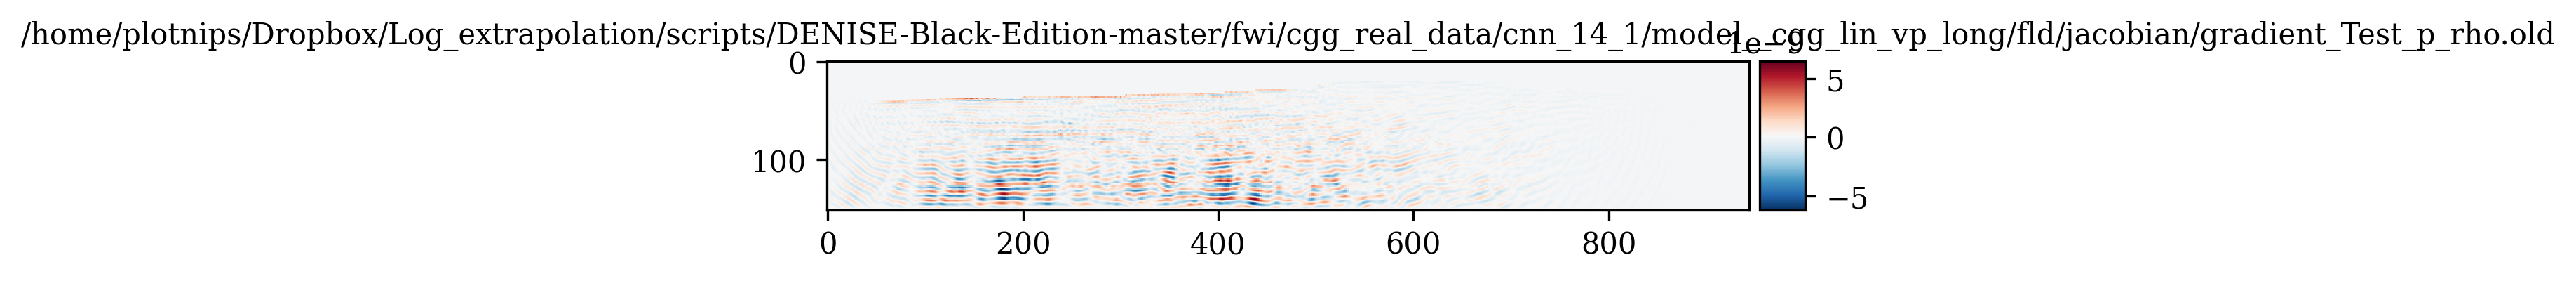

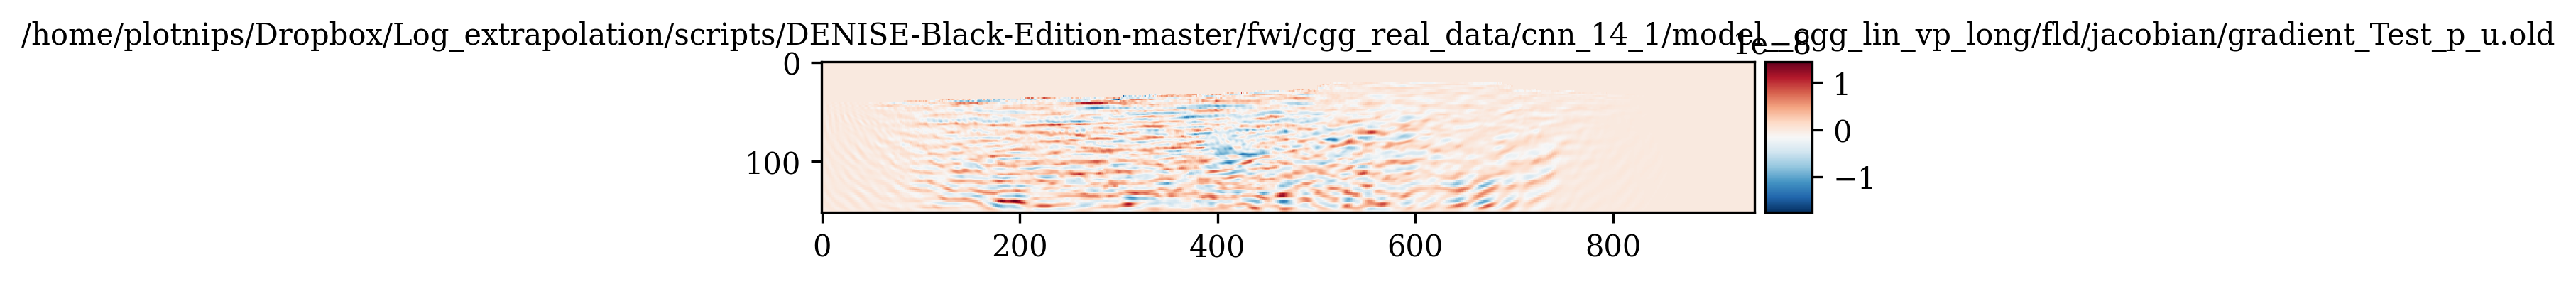

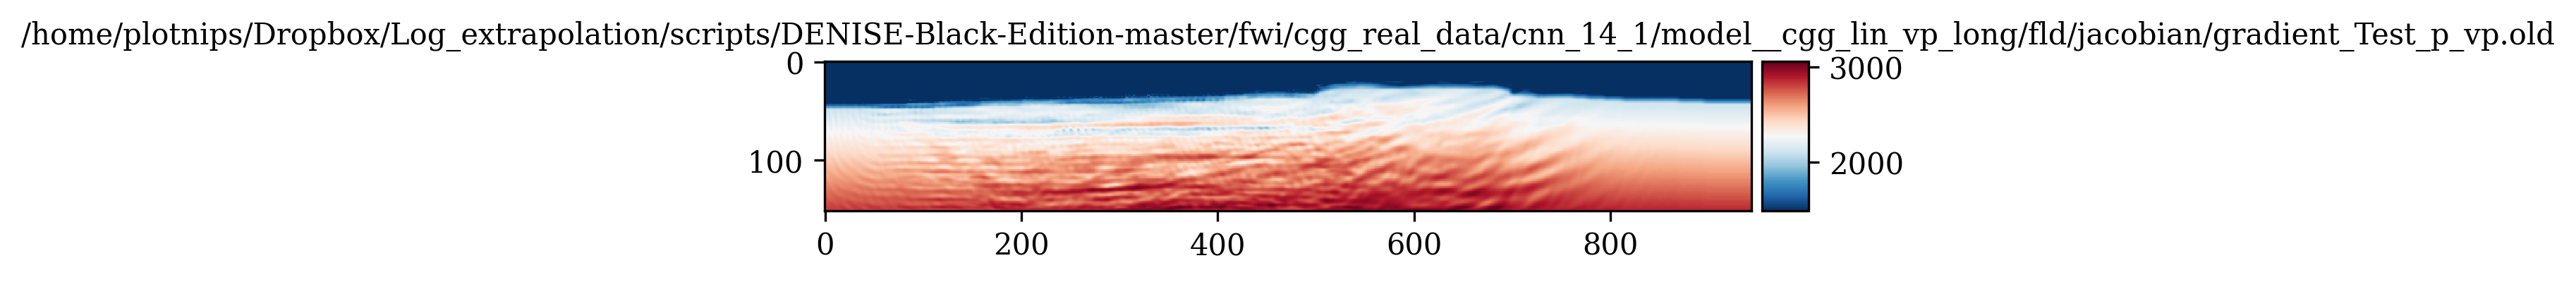

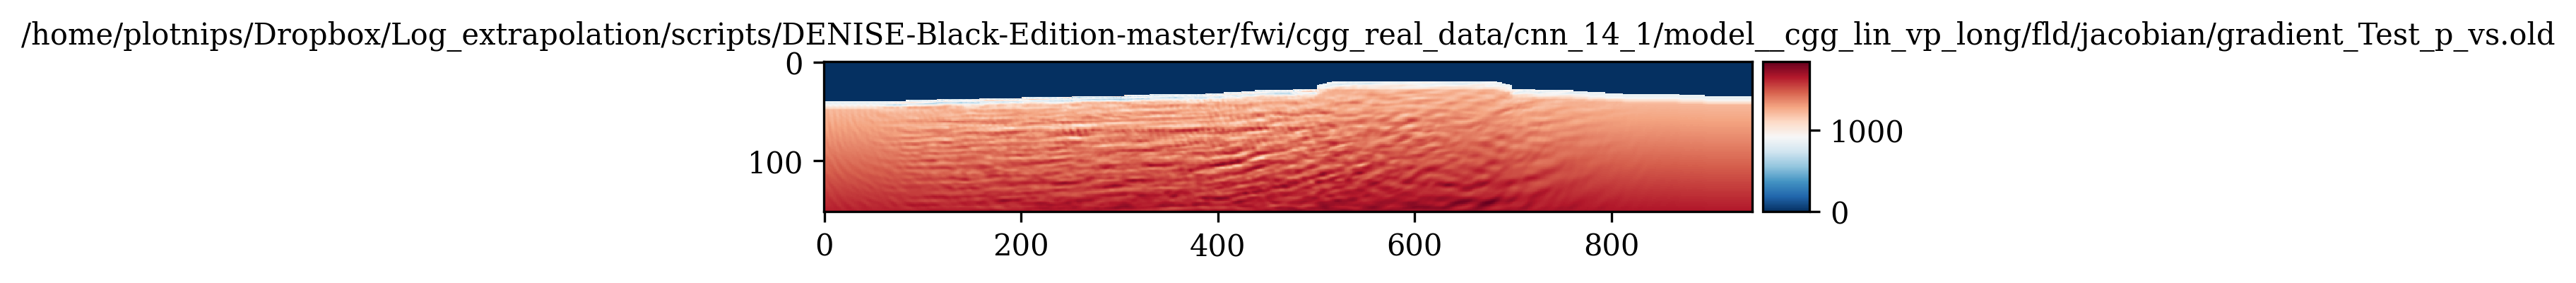

In [15]:
d.verbose = 0
grads, fnames = d.get_fwi_gradients(return_filenames=True)
for g, f in zip(grads, fnames):
    plot_model(g, f)

In [13]:
def get_model_last():
    all_fnames = []
    # vps, fnames = d.get_fwi_models(['vp', 'stage'], return_filenames=True)
    vps, fnames = d.get_fwi_models(['vp'], return_filenames=True)
    all_fnames += fnames
    vss, fnames = d.get_fwi_models(['vs'], return_filenames=True)
    all_fnames += fnames
    rhos, fnames = d.get_fwi_models(['rho'], return_filenames=True)
    all_fnames += fnames
    print(all_fnames)
    if all_fnames:
        for f in all_fnames:
            if not f.split('/')[-1] in os.listdir(f'{root_fwi}start/'):
                command = f'cp {f} {root_fwi}start/'
                print(command)
                os.system(command)
    if vps:
        print(f'Init new starting model from {fnames[-1]}')
        model_last = api.Model(vps[-1], vss[-1], rhos[-1], dx)
    # print(vps)
    return model_last
    # return None
model_last=get_model_last()

[]


UnboundLocalError: local variable 'model_last' referenced before assignment

# Compare wavefiedls before/after

In [ ]:
vps, fnames = d.get_fwi_models(['vp_stage'], return_filenames=True)
vss, fnames = d.get_fwi_models(['vs_stage'], return_filenames=True)
rhos, fnames = d.get_fwi_models(['rho_stage'], return_filenames=True)
print(d.save_folder)
if vps:
    model_last = api.Model(vps[-1], vss[-1], rhos[-1], dx)
    print(f'Found last model at {fnames[-1]}')
else:
    print(f'Not found the inverted model in {d.save_folder}!')